In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from nltk.corpus import wordnet
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
import nltk

In [2]:
news_dataset = pd.read_csv('train.csv')
news_dataset

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


## Data Cleaning
### Missing values

In [3]:
## Checking for missing values
news_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

The number of missing values of text and title are relatively low. So these instances can be removed. The number of missing values of the author column are more than that of the columns title and text. ALthough they are still relatively low, so they can be filled in with the most common. 

In [4]:
news_dataset['author'].value_counts()

Pam Key                                243
admin                                  193
Jerome Hudson                          166
Charlie Spiering                       141
John Hayward                           140
                                      ... 
thecraziesarerunningtheasylum            1
Eric Lichtblau and Michael D. Shear      1
Omar Al-Jawoshy and Sewell Chan          1
Sen. Ted Cruz (R-TX)                     1
Rick Gladstone and Somini Sengupta       1
Name: author, Length: 4201, dtype: int64

In [5]:
news_dataset['author'] = news_dataset['author'].fillna("Pam Key")

In [6]:
news_dataset.loc[news_dataset['author'].isna()]

,id,title,author,text,label


In [7]:
news_dataset.isnull().sum()

id          0
title     558
author      0
text       39
label       0
dtype: int64

In [8]:
news_dataset = news_dataset.dropna()

In [9]:
news_dataset.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

### Detecting outliers

C:\Users\gebruiker\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label'>

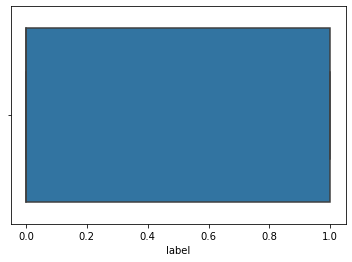

In [10]:
# Label are the only numerical values(main feature), so we check if it contains outliers.
sns.boxplot(news_dataset['label'])

It does not contain any outliers.

Next step is to create new feature out of the existing features.

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
# text word count
news_dataset['word_count'] = news_dataset['text'].apply(lambda x: len(str(x).split()))
print(news_dataset[news_dataset['label']==1]['word_count'].mean()) # fake articles
print(news_dataset[news_dataset['label']==0]['word_count'].mean()) # reliable articles

674.2979828850856
878.9965341292


<ipython-input-13-98f49e29e1bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['word_count'] = news_dataset['text'].apply(lambda x: len(str(x).split()))


In [14]:
news_dataset.head()

,id,title,author,text,label,word_count
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,710
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,557
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,154


<AxesSubplot:>

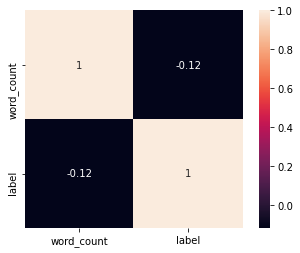

In [15]:
cols = ['word_count', 'label']
corrmat = news_dataset[cols].corr()
sns.heatmap(corrmat, square=True, annot=True)

A shown above the correlation between the reliabilty and the wordcount is very low. So we are trying a new feature.

In [16]:
news_dataset['Avg_length'] = news_dataset["text"].apply(lambda x: np.mean([len(w) for w in x.split()]))
print(news_dataset[news_dataset['label'] == 1]['Avg_length'].mean())
print(news_dataset[news_dataset['label'] == 0]['Avg_length'].mean())

C:\Users\gebruiker\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


5.122882537332296
4.932543698593874


<ipython-input-16-a1ca0f0d26f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['Avg_length'] = news_dataset["text"].apply(lambda x: np.mean([len(w) for w in x.split()]))


<AxesSubplot:>

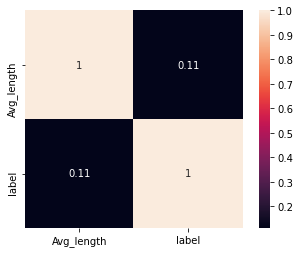

In [17]:
cols = ['Avg_length', 'label']
corrmat = news_dataset[cols].corr()
sns.heatmap(corrmat, square=True, annot=True)

The average length of the text has some higher correlation than the word count feature

Now we are investigating if there is a correlation between the author and the reliability of the news.

In [21]:
news_dataset.loc[news_dataset['author']== 'Pam Key']

,id,title,author,text,label,word_count,Avg_length
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Pam Key,Ever wonder how Britain’s most iconic pop pian...,1,489,4.570552
8,8,Excerpts From a Draft Script for Donald Trump’...,Pam Key,Donald J. Trump is scheduled to make a highly ...,0,1440,4.670833
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,Pam Key,Email \nSince Donald Trump entered the electio...,1,377,4.899204
22,22,Rob Reiner: Trump Is ’Mentally Unstable’ - Bre...,Pam Key,"Sunday on MSNBC’s “AM Joy,” actor and director...",0,206,4.237864
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,Pam Key,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,484,4.754132
...,...,...,...,...,...,...,...
20728,20728,Trump warns of World War III if Clinton is ele...,Pam Key,Email Donald Trump warned in an interview Tues...,1,773,4.870634
20745,20745,Thomas Frank Explores Whether Hillary Clinton ...,Pam Key,Thomas Frank Explores Whether Hillary Clinton ...,1,457,4.862144
20757,20757,Rubio on Russia Probe: ’I Wouldn’t Use the Ter...,Pam Key,Sen. Marco Rubio says he wouldn’t use the term...,0,145,4.517241
20768,20768,Osama bin Laden’s older brother rents out luxu...,Pam Key,Osama bin Laden’s older brother rents out luxu...,1,283,5.236749


As shown a above the most common author does not have always a real or a fake news.